In [1]:
import pandas as pd
import numpy as np

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

from pmdarima import auto_arima
from statsmodels.tsa.arima_model import ARIMA

import statsmodels.api as sm
import statsmodels.tsa.api as smt

from sklearn.metrics import mean_squared_error
from math import sqrt

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [2]:
pip install statsmodels --upgrade

Note: you may need to restart the kernel to use updated packages.


### 1. Выберите ряд из первого задания.



In [3]:
airline = pd.read_csv('international-airline-passengers.csv', names=['Month', 'Passengers'], header=0)

In [4]:
airline.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Month       144 non-null    object
 1   Passengers  144 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ KB


In [5]:
print(airline['Passengers'].mode()[0])
print(airline['Passengers'].mean())
print(airline['Passengers'].median())
print(np.std(airline['Passengers'], ddof=1))
print(airline['Passengers'].value_counts().head(5))

229
280.2986111111111
265.5
119.96631694294321
Passengers
229    3
306    2
405    2
242    2
196    2
Name: count, dtype: int64


In [6]:
airline['Passengers'] = airline['Passengers'].fillna(airline['Passengers'].mean())

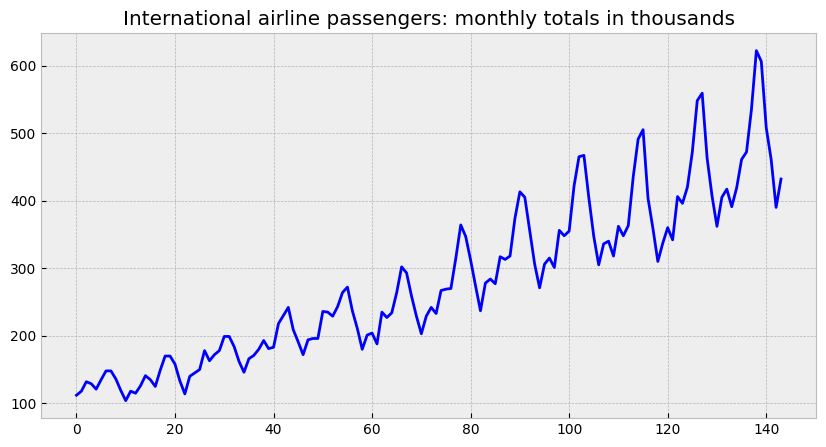

In [7]:
with plt.style.context('bmh'):
    plt.figure(figsize=(10, 5))
    plt.title('International airline passengers: monthly totals in thousands')
    plt.plot(airline['Passengers'], color='blue')

In [8]:
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [9]:
def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (5, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))
        qq_ax = plt.subplot2grid(layout, (4, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)
        sm.qqplot(y, line='s', ax=qq_ax)
        
        plt.tight_layout()
    return

### 2.Постройте его модель ARIMA.

In [10]:
series = airline['Passengers']
series.shape

(144,)

In [11]:
test_stationarity(series)

Results of Dickey-Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [12]:
from scipy.stats import boxcox

In [13]:
series_count = boxcox(series, 0)
series_count = np.diff(series_count, 12)

In [14]:
series_count_fit = auto_arima(series_count, trace=True, suppress_warnings=True)
series_count_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=1460.883, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=1290.027, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1458.883, Time=0.00 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=1107.176, Time=0.03 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=1019.504, Time=0.05 sec
 ARIMA(4,0,0)(0,0,0)[0] intercept   : AIC=852.328, Time=0.07 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=739.564, Time=0.09 sec
 ARIMA(5,0,1)(0,0,0)[0] intercept   : AIC=642.895, Time=0.29 sec
 ARIMA(4,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.22 sec
 ARIMA(5,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.31 sec
 ARIMA(4,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.23 sec
 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.23 sec

Best model:  ARIMA(5,0,1)(0,0,0)[0] intercept
Total fit time: 1.7

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  132
Model:               SARIMAX(5, 0, 1)   Log Likelihood                -313.448
Date:                Fri, 26 Jan 2024   AIC                            642.895
Time:                        14:49:21   BIC                            665.958
Sample:                             0   HQIC                           652.267
                                - 132                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0014      0.008     -0.166      0.868      -0.018       0.015
ar.L1         -3.4272      0.076    -45.301      0.000      -3.576      -3.279
ar.L2         -5.5489      0.219    -25.333      0.000      -5.978      -5.120
ar.L3         -5.2462      0.300    -17.476      0.000      -5.835      -4.658
ar.L4         -2.8939      0.218    -13.257      0.000      -3.322      -2.466
ar.L5         -0.7421      0.074    -10.074      0.000      -0.886      -0.598
ma.L1         -0.9898      0.305     -3.244      0.001      -1.588      -0.392
sigma2         5.5902      1.860      3.005      0.003       1.944       9.236
===================================================================================
Ljung-Box (L1) (Q):                   3.91   Jarque-Bera (JB):                 2.14
Prob(Q):                              0.05   Prob(JB):                         0.34
Heteroskedasticity (H):               1.19   Skew:                             0.24
Prob(H) (two-sided):                  0.56   Kurtosis:                         2.61
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [15]:
leng = int(series.shape[0]*0.8)
train = series[:leng]
test = series[leng:]
print(train.shape, test.shape)

(115,) (29,)


In [17]:
model = sm.tsa.ARIMA(train, order=(5,0,1))
model = model.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             Passengers   No. Observations:                  115
Model:                 ARIMA(5, 0, 1)   Log Likelihood                -529.679
Date:                Fri, 26 Jan 2024   AIC                           1075.359
Time:                        14:50:07   BIC                           1097.318
Sample:                             0   HQIC                          1084.272
                                - 115                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        239.9679     98.711      2.431      0.015      46.497     433.438
ar.L1          0.6132      0.149      4.107      0.000       0.321       0.906
ar.L2          0.3756      0.183      2.048      0.041       0.016       0.735
ar.L3         -0.1122      0.104     -1.078      0.281      -0.316       0.092
ar.L4         -0.1338      0.143     -0.935      0.350      -0.414       0.147
ar.L5          0.2224      0.114      1.949      0.051      -0.001       0.446
ma.L1          0.8021      0.128      6.261      0.000       0.551       1.053
sigma2       565.5509    104.014      5.437      0.000     361.688     769.414
===================================================================================
Ljung-Box (L1) (Q):                   0.11   Jarque-Bera (JB):                 6.03
Prob(Q):                              0.74   Prob(JB):                         0.05
Heteroskedasticity (H):               5.11   Skew:                             0.47
Prob(H) (two-sided):                  0.00   Kurtosis:                         2.37
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### 3.Оформите отчёт в Jupyter-ноутбук.

Results of Dickey-Fuller Test:
Test Statistic                  -3.128706
p-value                          0.024500
#Lags Used                      12.000000
Number of Observations Used    102.000000
Critical Value (1%)             -3.496149
Critical Value (5%)             -2.890321
Critical Value (10%)            -2.582122
dtype: float64


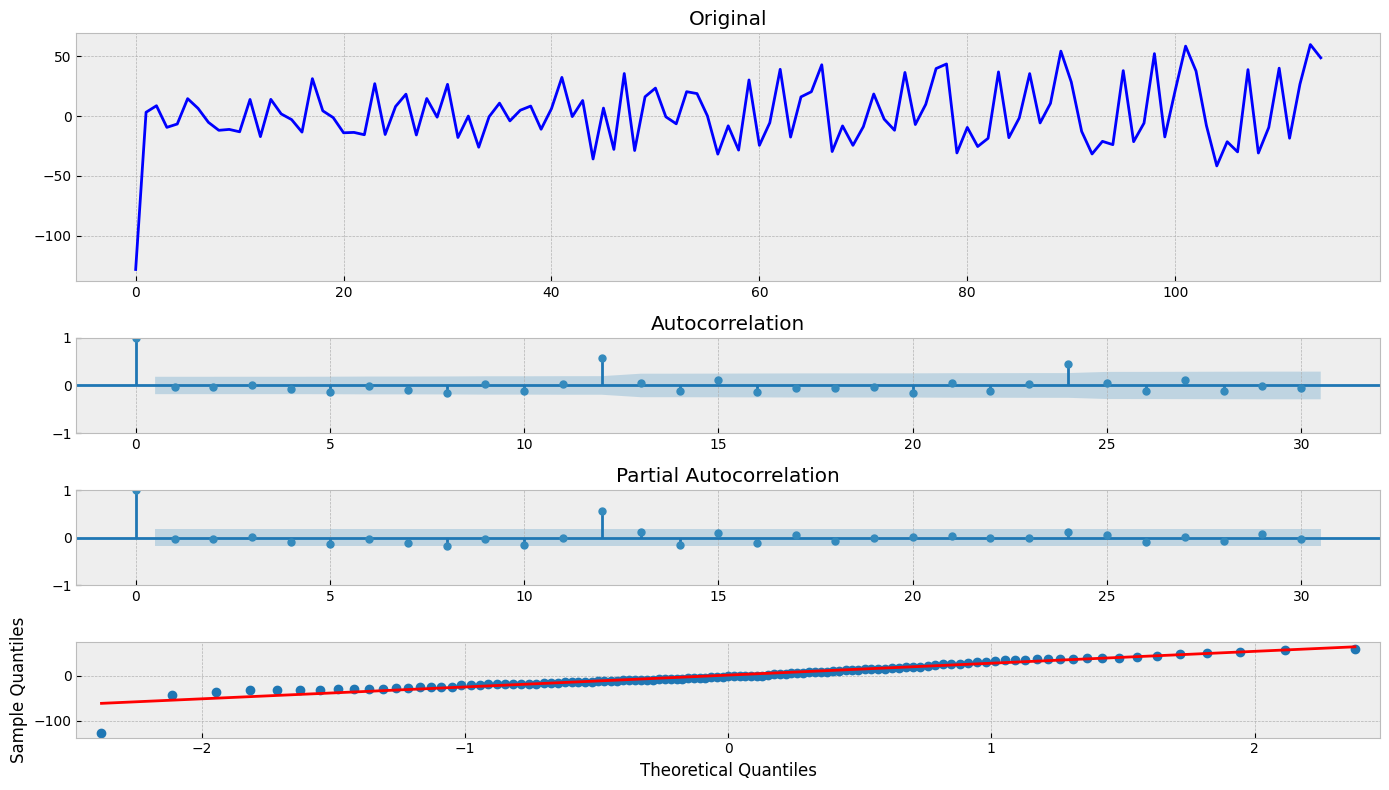

In [18]:
tsplot(model.resid, lags=30)